In [ ]:
# CORA dataset: https://graphsandnetworks.com/the-cora-dataset/

In [ ]:
# !pip install -q torch==1.12.0

In [1]:
import torch as th
print(th.__version__)

1.12.1+cu113


In [2]:
%%time
# Install required packages.
import os
import torch as th
os.environ['TORCH'] = th.__version__
print(th.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 51 kB 163 kB/s 
CPU times: user 6.47 s, sys: 1 s, total: 7.48 s
Wall time: 14min 59s


In [3]:
!pip install -q igraph==0.9.11

     |████████████████████████████████| 3.1 MB 5.0 MB/s 


In [4]:
import os
from os.path import join as p_join
import sys
from tqdm.notebook import tqdm
import time
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp
import numpy as np
import pandas as pd

# Deep learning related imports
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [5]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [6]:
# # Подключение данных гугл диска
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


---

In [7]:
data_dir = '/content/drive/MyDrive/Datasets/cora'

In [8]:
content = pd.read_csv(p_join(data_dir, 'cora.content'), sep='\t', header=None)
print(f"content.shape: {content.shape[0]:,} x {content.shape[1]:}")
node_features = content.iloc[:, 1:-1].values
target = content.iloc[:, -1].values
target_num = content.iloc[:, -1].astype('category').cat.codes.astype('int').values
node_idxs = content.iloc[:, 0].values
node2id = {node: i for i, node in enumerate(node_idxs)}

edgelist = pd.read_csv(p_join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist['source'] = edgelist['source'].map(node2id)
edgelist['target'] = edgelist['target'].map(node2id)
edgelist["label"] = "cites"
print(f"len(edgelist): {len(edgelist)}")

content.shape: 2,708 x 1435
len(edgelist): 5429


In [9]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")

In [10]:
np.random.seed(42)
mask = np.random.choice([0, 1, 2], p=[0.1, 0.4, 0.5], size=node_idxs.shape[0])
train_mask = (mask == 0)
val_mask = (mask == 1)
test_mask = (mask == 2)

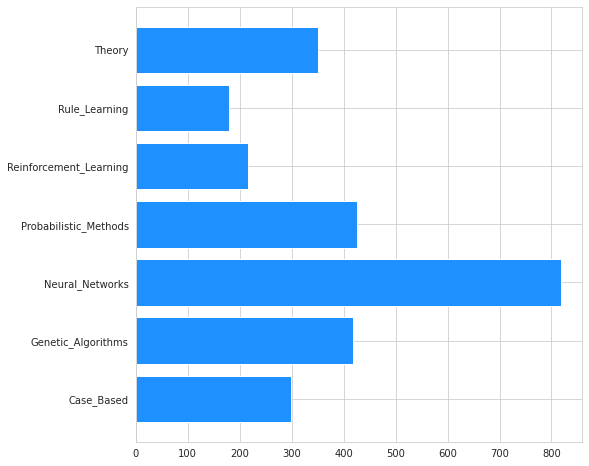

In [11]:
# classes distribution
target_names, cnts = np.unique(target, return_counts=True)
plt.barh(target_names, cnts, color='dodgerblue');

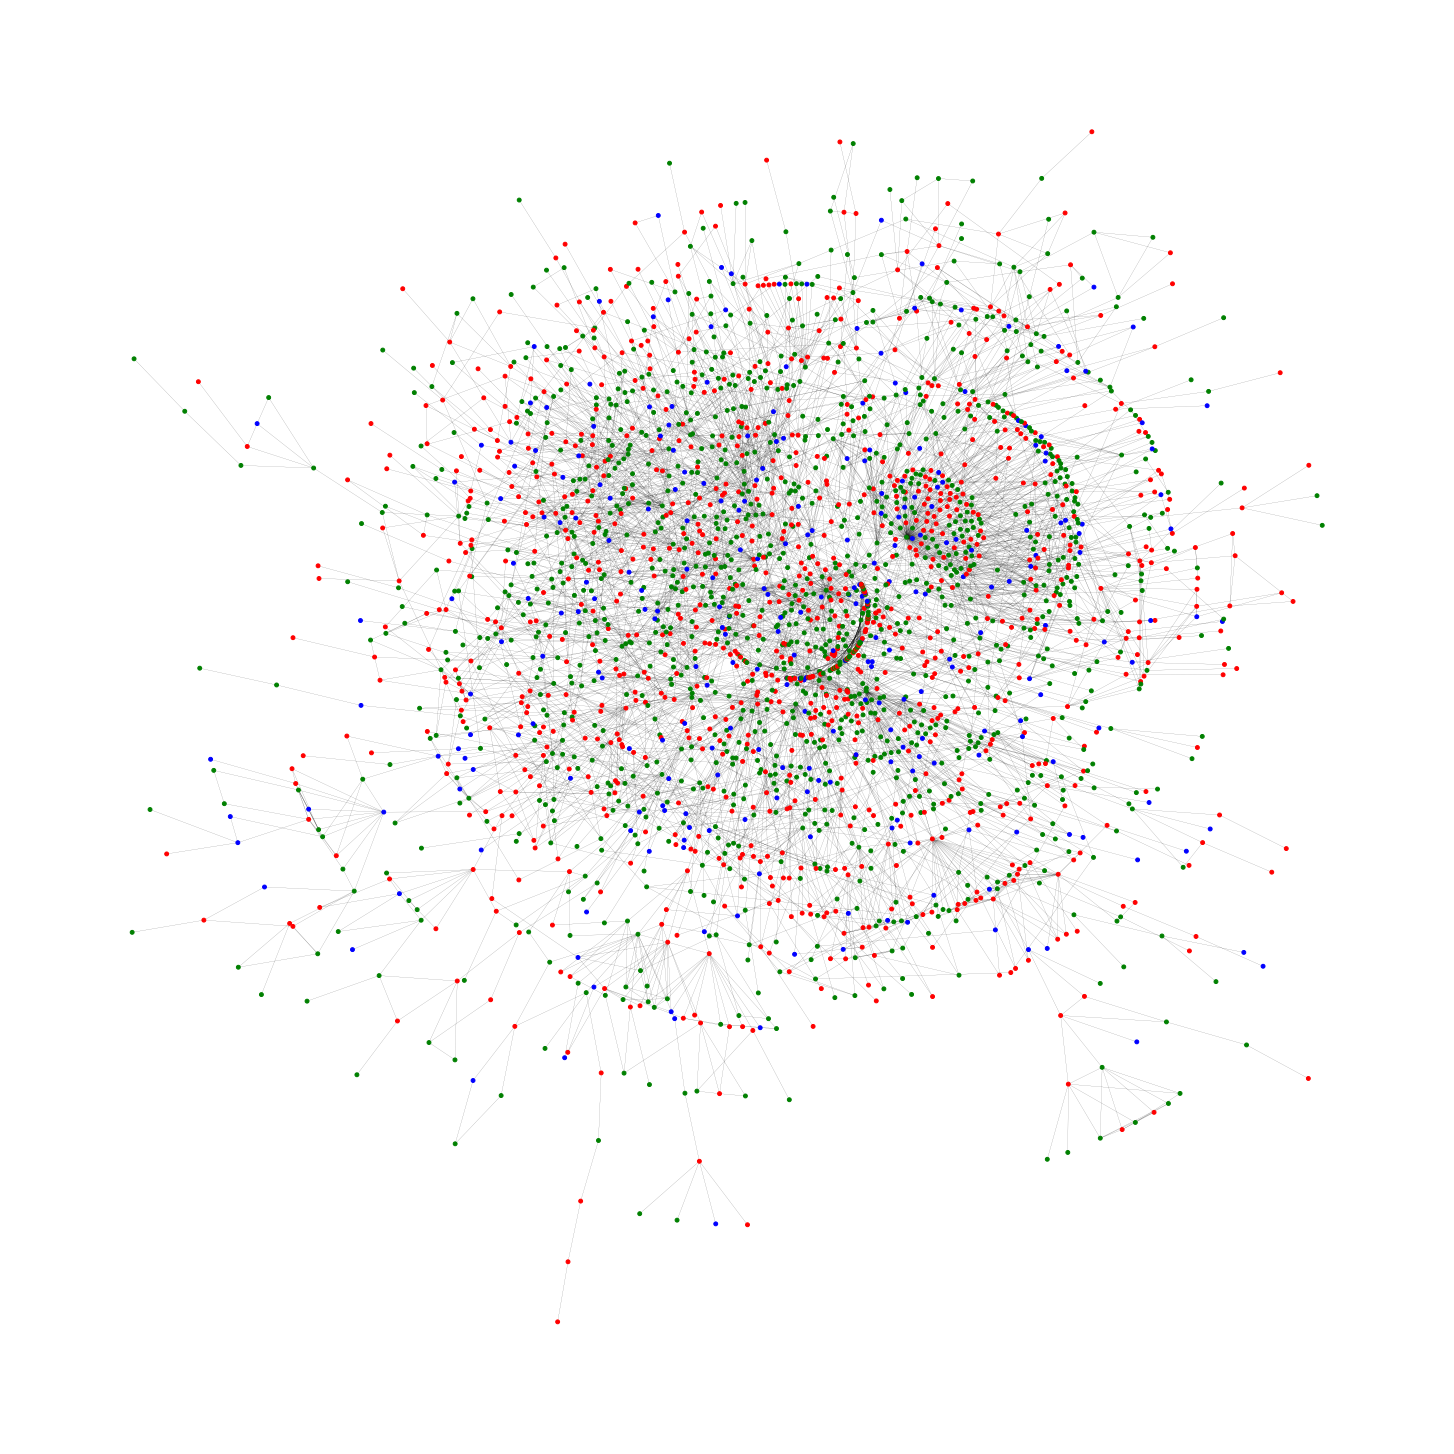

In [ ]:
plt.figure(figsize=(20, 20))
colors = np.array(['blue', 'red', 'green', 'magenta', 'yellow', 'pink', 'orange'])
nx.draw(Gnx, pos=nx.kamada_kawai_layout(Gnx), node_size=15, width=0.1, node_color=colors[mask])

In [12]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [13]:
import torch as th
from torch_geometric.data import Data

edge_index = th.LongTensor(np.hstack([
    edgelist[['source', 'target']].values.T,
    edgelist[['source', 'target']].values[:, ::-1].T
]))
x = th.FloatTensor(node_features)
data = Data(
    x=x, 
    edge_index=edge_index, 
    y=th.LongTensor(target_num), 
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)
data

Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Training MLP as a baseline solution

In [14]:
import torch as th
from torch import nn
from torch.nn import functional as F
from torch import optim

In [15]:
class MLP(nn.Module):
    def __init__(
        self, 
        input_features_size: int=data.x.shape[1], 
        hidd1_size: int=16, 
        n_classes: int=data.y.unique().shape[0]
    ):
        super(MLP, self).__init__()
        th.manual_seed(42)
        self.linear1 = nn.Linear(in_features=input_features_size, out_features=hidd1_size)
        self.clf = nn.Linear(in_features=hidd1_size, out_features=n_classes)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.clf(out)
        return out

In [ ]:
mlp_model = MLP(
    input_features_size=data.x.shape[1],
    n_classes=data.y.unique().shape[0]
)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(mlp_model.parameters(), lr=1e-2, weight_decay=5e-4)

mlp_model

MLP(
  (linear1): Linear(in_features=1433, out_features=16, bias=True)
  (clf): Linear(in_features=16, out_features=7, bias=True)
)

In [ ]:
EPOCHS = 300
mlp_model.train()
mlp_model.cuda()
criterion.cuda()
train_loss = []
val_loss = []
x_cuda = data.x.cuda()
y_cuda = data.y.cuda()
best_val_loss, best_val_epoch = None, None

for epoch in tqdm(range(EPOCHS)):
    mlp_model.cuda()
    st = time.perf_counter()
    # training
    mlp_model.train()
    opt.zero_grad()
    y_pred = mlp_model(x_cuda)
    loss = criterion(y_pred[data.train_mask], y_cuda[data.train_mask])
    loss.backward()
    opt.step()
    train_loss.append(loss.item())
    
    # evaluation
    with th.no_grad():
        mlp_model.eval()
        #y_pred = mlp_model(data.x)
        loss = criterion(y_pred[data.val_mask], y_cuda[data.val_mask])
        val_loss.append(loss.item())
        if best_val_loss is None:
            best_val_loss = loss.item()
            best_val_epoch = epoch
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            best_val_epoch = epoch
            th.save(
                mlp_model.cpu().state_dict(), 
                '/content/drive/MyDrive/Trained models weights/MLP for CORA dataset/mlp_best_val_params.pkl'
            )
        if loss.item() > best_val_loss and epoch > best_val_epoch + 50:
            break
    end = time.perf_counter()
        
    log_string = ''
    log_string += f'epoch: {epoch+1} | train_loss: {train_loss[-1]} | val_loss: {val_loss[-1]} | Time: {round(end - st)} secs.'
    print(log_string)
    

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 1 | train_loss: 1.9393304586410522 | val_loss: 1.9388792514801025 | Time: 0 secs.
epoch: 2 | train_loss: 1.8824925422668457 | val_loss: 1.9101364612579346 | Time: 0 secs.
epoch: 3 | train_loss: 1.8161461353302002 | val_loss: 1.88266921043396 | Time: 0 secs.
epoch: 4 | train_loss: 1.727352499961853 | val_loss: 1.8386343717575073 | Time: 0 secs.
epoch: 5 | train_loss: 1.6359204053878784 | val_loss: 1.8029260635375977 | Time: 0 secs.
epoch: 6 | train_loss: 1.543387770652771 | val_loss: 1.7572507858276367 | Time: 0 secs.
epoch: 7 | train_loss: 1.4220621585845947 | val_loss: 1.7393549680709839 | Time: 0 secs.
epoch: 8 | train_loss: 1.3315457105636597 | val_loss: 1.6872782707214355 | Time: 0 secs.
epoch: 9 | train_loss: 1.264026165008545 | val_loss: 1.6820441484451294 | Time: 0 secs.
epoch: 10 | train_loss: 1.1531490087509155 | val_loss: 1.6549140214920044 | Time: 0 secs.
epoch: 11 | train_loss: 1.131842851638794 | val_loss: 1.6368504762649536 | Time: 0 secs.
epoch: 12 | train_loss: 0

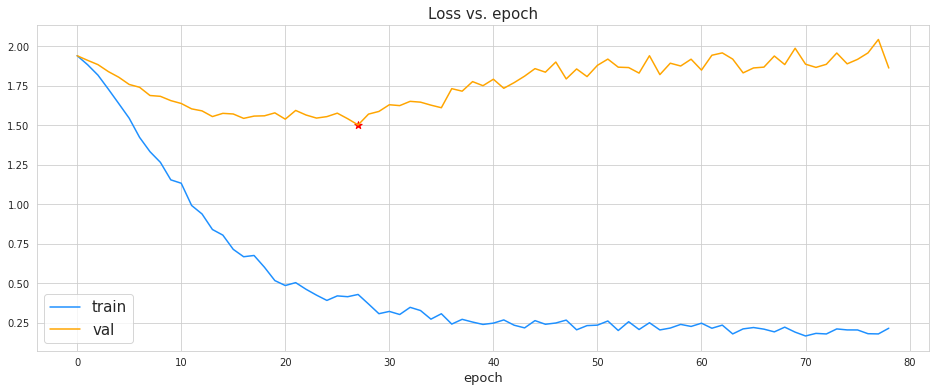

In [ ]:
plt.figure(figsize=(16, 6))
plt.title(f'Loss vs. epoch', fontsize=15);
plt.plot(train_loss, color='dodgerblue', label='train')
plt.plot(val_loss, color='orange', label='val')
plt.scatter(np.argmin(val_loss), val_loss[np.argmin(val_loss)], color='red', marker='*', s=60)
plt.legend(fontsize=15);
plt.xlabel('epoch', fontsize=13);

In [16]:
# loading model and test predictions on test nodes
trained_params_path = '/content/drive/MyDrive/Trained models weights/MLP for CORA dataset/mlp_best_val_params.pkl'
trained_mlp_model = MLP()
trained_mlp_model.load_state_dict(th.load(trained_params_path))
trained_mlp_model.eval()

with th.no_grad():
    y_pred = trained_mlp_model(data.x[data.test_mask]).argmax(axis=1)
    y_true = data.y[data.test_mask]

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

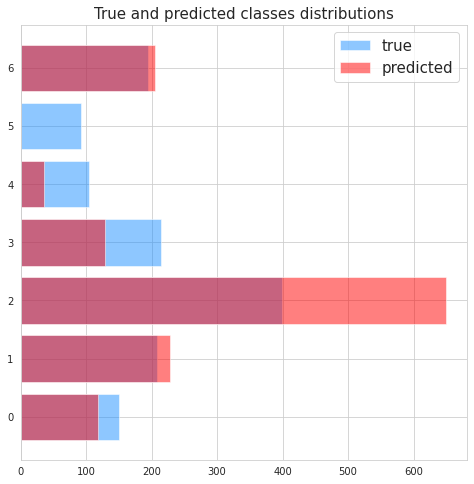

In [18]:
# classes distribution
plt.title(f'True and predicted classes distributions', fontsize=15);
target_names, cnts = np.unique(y_true, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='dodgerblue', alpha=0.5, label='true');

target_names, cnts = np.unique(y_pred, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='red', label='predicted', alpha=0.5);
plt.legend(fontsize=15);

In [19]:
print(accuracy_score(
    y_true=y_true,
    y_pred=y_pred
))

0.5835777126099707


Let's train GNN

In [20]:
from torch_geometric import nn as gnn

In [93]:
class GNN(nn.Module):
    def __init__(
        self, 
        input_features_size: int=data.x.shape[1], 
        hidd1_size: int=16, 
        n_classes: int=data.y.unique().shape[0]
    ):
        super(GNN, self).__init__()
        th.manual_seed(42)
        self.gcn1 = gnn.GCNConv(
            in_channels=input_features_size, 
            out_channels=hidd1_size,
        )
        self.gcn2 = gnn.GCNConv(
            in_channels=hidd1_size, 
            out_channels=n_classes,
        )
        
    def forward(self, x, edge_index):
        out = self.gcn1(x, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gcn2(out, edge_index)
        return out

In [103]:
gcn_model = GNN(
    input_features_size=data.x.shape[1],
    n_classes=data.y.unique().shape[0]
)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(gcn_model.parameters(), lr=1e-2, weight_decay=5e-4)

gcn_model

GNN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)

Let's visualize embeddings of the initialized network

In [95]:
from sklearn.manifold import TSNE

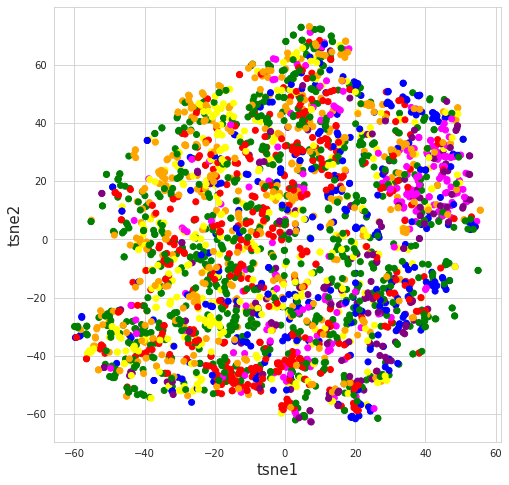

In [102]:
x_embed = gcn_model(data.x, data.edge_index).detach().numpy()
x_tsne = TSNE(n_components=2).fit_transform(x_embed)
colors = np.array(['blue', 'red', 'green', 'orange', 'magenta', 'purple', 'yellow'])
plt.figure(figsize=(8, 8))
plt.title(f'Embeddings after training', fontsize=20)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], color=colors[data.y.detach().numpy()]);
plt.xlabel(f'tsne1', fontsize=15);
plt.ylabel(f'tsne2', fontsize=15);

In [104]:
DEVICE = 'cpu'
EPOCHS = 300
gcn_model.train()
gcn_model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
val_loss = []
x_device = data.x.to(DEVICE)
edge_index_device = data.edge_index.to(DEVICE)
y_device = data.y.to(DEVICE)
best_val_loss, best_val_epoch = None, None

for epoch in tqdm(range(EPOCHS)):
    gcn_model.to(DEVICE)
    st = time.perf_counter()
    # training
    gcn_model.train()
    opt.zero_grad()
    y_pred = gcn_model(x_device, edge_index_device)
    loss = criterion(y_pred[data.train_mask], y_device[data.train_mask])
    loss.backward()
    opt.step()
    train_loss.append(loss.item())
    
    # evaluation
    with th.no_grad():
        gcn_model.eval()
        #y_pred = gcn_model(x_device, edge_index_device)
        loss = criterion(y_pred[data.val_mask], y_device[data.val_mask])
        val_loss.append(loss.item())
        if best_val_loss is None:
            best_val_loss = loss.item()
            best_val_epoch = epoch
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            best_val_epoch = epoch
            th.save(
                gcn_model.cpu().state_dict(), 
                '/content/drive/MyDrive/Trained models weights/GNN for CORA dataset/gcn_best_val_params.pkl'
            )
        if loss.item() > best_val_loss and epoch > best_val_epoch + 50:
            break
    end = time.perf_counter()
        
    log_string = ''
    log_string += f'epoch: {epoch+1} | train_loss: {train_loss[-1]} | val_loss: {val_loss[-1]} | Time: {round(end - st)} secs.'
    print(log_string)
    

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 1 | train_loss: 1.9690821170806885 | val_loss: 1.969974160194397 | Time: 0 secs.
epoch: 2 | train_loss: 1.836281180381775 | val_loss: 1.8834401369094849 | Time: 0 secs.
epoch: 3 | train_loss: 1.7255311012268066 | val_loss: 1.814088225364685 | Time: 0 secs.
epoch: 4 | train_loss: 1.6309292316436768 | val_loss: 1.7417925596237183 | Time: 0 secs.
epoch: 5 | train_loss: 1.509020209312439 | val_loss: 1.6674991846084595 | Time: 0 secs.
epoch: 6 | train_loss: 1.3680367469787598 | val_loss: 1.5628241300582886 | Time: 0 secs.
epoch: 7 | train_loss: 1.2753546237945557 | val_loss: 1.5259668827056885 | Time: 0 secs.
epoch: 8 | train_loss: 1.1770684719085693 | val_loss: 1.454475998878479 | Time: 0 secs.
epoch: 9 | train_loss: 1.074694037437439 | val_loss: 1.371401309967041 | Time: 0 secs.
epoch: 10 | train_loss: 0.9873129725456238 | val_loss: 1.3229268789291382 | Time: 0 secs.
epoch: 11 | train_loss: 0.9086996912956238 | val_loss: 1.2788132429122925 | Time: 0 secs.
epoch: 12 | train_loss: 0.

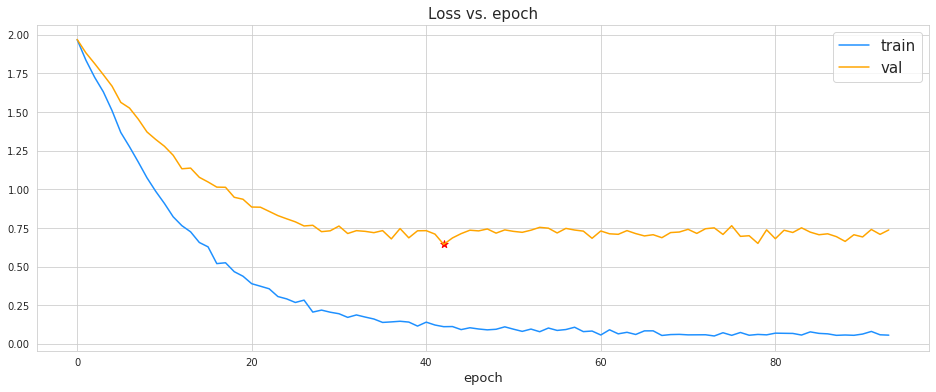

In [105]:
plt.figure(figsize=(16, 6))
plt.title(f'Loss vs. epoch', fontsize=15);
plt.plot(train_loss, color='dodgerblue', label='train')
plt.plot(val_loss, color='orange', label='val')
plt.scatter(np.argmin(val_loss), val_loss[np.argmin(val_loss)], color='red', marker='*', s=60)
plt.legend(fontsize=15);
plt.xlabel('epoch', fontsize=13);

In [106]:
# loading model and test predictions on test nodes
trained_params_path = '/content/drive/MyDrive/Trained models weights/GNN for CORA dataset/gcn_best_val_params.pkl'
trained_gcn_model = GNN()
trained_gcn_model.load_state_dict(th.load(trained_params_path))
trained_gcn_model.eval()

with th.no_grad():
    y_pred = trained_gcn_model(data.x, data.edge_index)[data.test_mask].argmax(axis=1)
    y_true = data.y[data.test_mask]

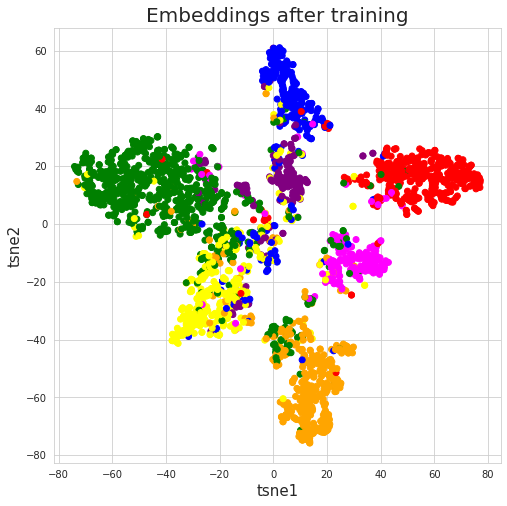

In [108]:
x_embed = trained_gcn_model(data.x, data.edge_index).detach().numpy()
x_tsne = TSNE(n_components=2).fit_transform(x_embed)
colors = np.array(['blue', 'red', 'green', 'orange', 'magenta', 'purple', 'yellow'])
plt.figure(figsize=(8, 8))
plt.title(f'Embeddings after training', fontsize=20)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], color=colors[data.y.detach().numpy()]);
plt.xlabel(f'tsne1', fontsize=15);
plt.ylabel(f'tsne2', fontsize=15);

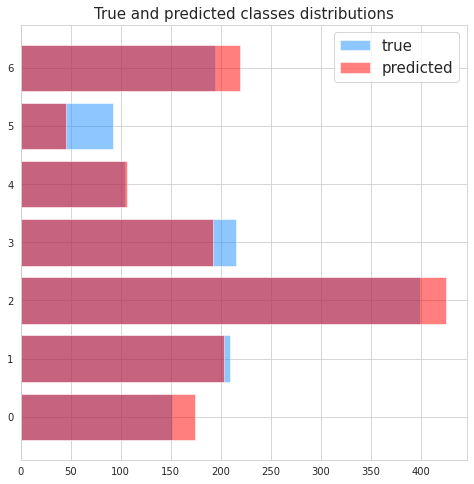

In [62]:
# classes distribution
plt.title(f'True and predicted classes distributions', fontsize=15);
target_names, cnts = np.unique(y_true, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='dodgerblue', alpha=0.5, label='true');

target_names, cnts = np.unique(y_pred, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='red', label='predicted', alpha=0.5);
plt.legend(fontsize=15);

In [63]:
print(accuracy_score(
    y_true=y_true,
    y_pred=y_pred
))

0.8189149560117303


Let's train GAT network

In [64]:
class GAT(nn.Module):
    def __init__(
        self, 
        input_features_size: int=data.x.shape[1], 
        hidd1_size: int=16, 
        n_classes: int=data.y.unique().shape[0]
    ):
        super(GAT, self).__init__()
        th.manual_seed(42)
        self.gat1 = gnn.GATv2Conv(
            in_channels=input_features_size, 
            out_channels=hidd1_size,
        )
        self.gat2 = gnn.GATv2Conv(
            in_channels=hidd1_size, 
            out_channels=n_classes,
        )
        
    def forward(self, x, edge_index):
        out = self.gat1(x, edge_index)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gat2(out, edge_index)
        return out

In [87]:
gat_model = GAT(
    input_features_size=data.x.shape[1],
    n_classes=data.y.unique().shape[0]
)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(gat_model.parameters(), lr=1e-3, weight_decay=5e-4)

gat_model

GAT(
  (gat1): GATv2Conv(1433, 16, heads=1)
  (gat2): GATv2Conv(16, 7, heads=1)
)

In [88]:
from sklearn.metrics import accuracy_score

DEVICE = 'cpu'
EPOCHS = 300
EARLY_STOPPING_ROUNDS = 70
gat_model.train()
gat_model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
val_loss = []
x_device = data.x.to(DEVICE)
edge_index_device = data.edge_index.to(DEVICE)
y_device = data.y.to(DEVICE)
best_val_loss, best_val_epoch = None, None

for epoch in tqdm(range(EPOCHS)):
    gat_model.to(DEVICE)
    st = time.perf_counter()
    # training
    gat_model.train()
    opt.zero_grad()
    y_pred = gat_model(x_device, edge_index_device)
    loss = criterion(y_pred[data.train_mask], y_device[data.train_mask])
    loss.backward()
    opt.step()
    train_loss.append(loss.item())
    
    # evaluation
    with th.no_grad():
        gat_model.eval()
        #y_pred = gat_model(x_device, edge_index_device)
        loss = criterion(y_pred[data.val_mask], y_device[data.val_mask])
        val_loss.append(loss.item())
        if best_val_loss is None:
            best_val_loss = loss.item()
            best_val_epoch = epoch
        if loss.item() < best_val_loss:
            best_val_loss = loss.item()
            best_val_epoch = epoch
            th.save(
                gat_model.cpu().state_dict(), 
                '/content/drive/MyDrive/Trained models weights/GNN for CORA dataset/gat_best_val_params.pkl'
            )
        if loss.item() > best_val_loss and epoch > best_val_epoch + EARLY_STOPPING_ROUNDS:
            break
    end = time.perf_counter()
        
    val_accuracy = accuracy_score(
        y_true=y_device[data.val_mask].detach().numpy(),
        y_pred=y_pred[data.val_mask].detach().numpy().argmax(axis=1)
    )
    log_string = ''
    log_string += f'epoch: {epoch+1} | train_loss: {train_loss[-1]} | val_loss: {val_loss[-1]} | val_acc: {round(val_accuracy, 3)}| Time: {round(end - st)} secs.'
    print(log_string)
    

  0%|          | 0/300 [00:00<?, ?it/s]

epoch: 1 | train_loss: 1.9825390577316284 | val_loss: 1.9667320251464844 | val_acc: 0.15| Time: 0 secs.
epoch: 2 | train_loss: 1.9625238180160522 | val_loss: 1.9547216892242432 | val_acc: 0.145| Time: 0 secs.
epoch: 3 | train_loss: 1.9400670528411865 | val_loss: 1.939326286315918 | val_acc: 0.164| Time: 0 secs.
epoch: 4 | train_loss: 1.9237432479858398 | val_loss: 1.9255893230438232 | val_acc: 0.175| Time: 0 secs.
epoch: 5 | train_loss: 1.9064693450927734 | val_loss: 1.913730263710022 | val_acc: 0.19| Time: 0 secs.
epoch: 6 | train_loss: 1.8895920515060425 | val_loss: 1.9050122499465942 | val_acc: 0.204| Time: 0 secs.
epoch: 7 | train_loss: 1.8711888790130615 | val_loss: 1.889853835105896 | val_acc: 0.247| Time: 0 secs.
epoch: 8 | train_loss: 1.8461405038833618 | val_loss: 1.8755289316177368 | val_acc: 0.294| Time: 0 secs.
epoch: 9 | train_loss: 1.838023066520691 | val_loss: 1.8666945695877075 | val_acc: 0.332| Time: 0 secs.
epoch: 10 | train_loss: 1.8100781440734863 | val_loss: 1.8535

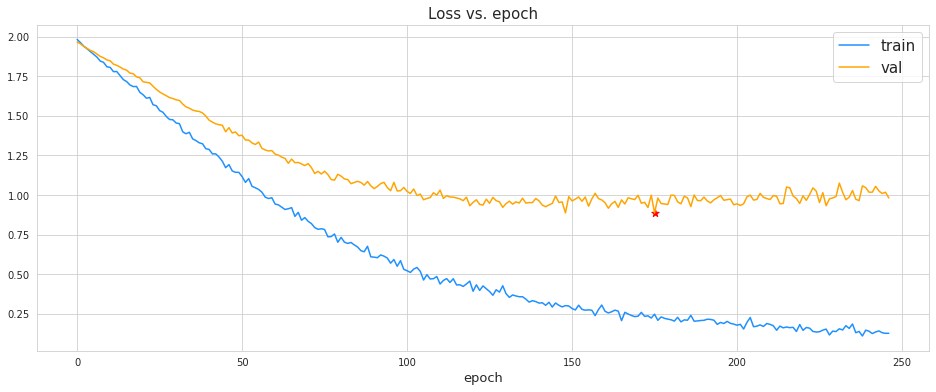

In [89]:
plt.figure(figsize=(16, 6))
plt.title(f'Loss vs. epoch', fontsize=15);
plt.plot(train_loss, color='dodgerblue', label='train')
plt.plot(val_loss, color='orange', label='val')
plt.scatter(np.argmin(val_loss), val_loss[np.argmin(val_loss)], color='red', marker='*', s=60)
plt.legend(fontsize=15);
plt.xlabel('epoch', fontsize=13);

In [90]:
# loading model and test predictions on test nodes
trained_params_path = '/content/drive/MyDrive/Trained models weights/GNN for CORA dataset/gat_best_val_params.pkl'
trained_gat_model = GAT()
trained_gat_model.load_state_dict(th.load(trained_params_path))
trained_gat_model.eval()

with th.no_grad():
    y_pred = trained_gat_model(data.x, data.edge_index)[data.test_mask].argmax(axis=1)
    y_true = data.y[data.test_mask]

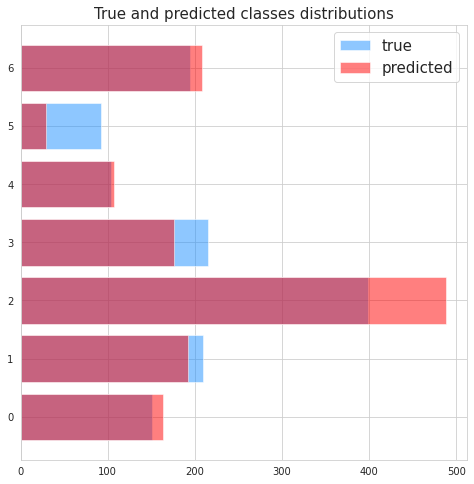

In [91]:
# classes distribution
plt.title(f'True and predicted classes distributions', fontsize=15);
target_names, cnts = np.unique(y_true, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='dodgerblue', alpha=0.5, label='true');

target_names, cnts = np.unique(y_pred, return_counts=True)
cnts = cnts[np.argsort(target_names)]
target_names = np.sort(target_names)
plt.barh(target_names, cnts, color='red', label='predicted', alpha=0.5);
plt.legend(fontsize=15);

In [92]:
print(accuracy_score(
    y_true=y_true,
    y_pred=y_pred
))

0.7778592375366569
